In [98]:
import collections

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
import seaborn as sns

In [99]:
import os
print(os.getcwd())

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    im = ax.imshow(data, **kwargs)

    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    for _, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=1)
    ax.tick_params(which="minor", bottom=False, left=False)
    return im, cbar

/home/nkprince007/uic/cs529/project/data


In [100]:
sns.set_style('white')

In [101]:
df_train = pd.read_csv('datasets/symptoms_modified.csv')
df_train.head()

,ID,collected.years,event.name,s1,s2,s3,s4,s5,s6,s7,...,s19,s20,s21,s22,s23,s24,s25,s26,s27,s28
0,10009,7.133333,Baseline,0,0,0,0,0,0.0,0.0,...,0,3,0,0,0,0,0,0,0,0
1,10009,8.013889,9 to 12 mos.,0,1,0,0,0,0.0,0.0,...,0,3,1,5,0,0,0,0,0,0
2,10009,8.475000,16 to 19 mos.,0,5,0,0,0,0.0,0.0,...,0,2,5,8,2,0,2,0,0,0
3,10009,9.063889,22 to 24 mos.,0,0,0,0,0,0.0,0.0,...,0,3,0,7,0,0,0,0,0,0
4,10009,10.255556,Past 2 Years 1,0,0,0,0,0,0.0,0.0,...,0,3,1,0,0,0,0,0,0,0


In [102]:
symptoms = pd.read_csv('datasets/symptom_questions.csv')
symptoms = symptoms.iloc[:, 2:3]
symptoms = [s.strip() for s in np.asarray(symptoms).flatten()]

In [103]:
df_train.describe()

,ID,collected.years,s1,s2,s3,s4,s5,s6,s7,s8,...,s19,s20,s21,s22,s23,s24,s25,s26,s27,s28
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,535.000000,535.000000,533.000000,...,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,4796.705224,4.562687,0.783582,1.917910,0.201493,1.550373,0.977612,0.768224,1.846729,0.992495,...,0.776119,2.264925,0.611940,1.067164,1.126866,0.916045,1.167910,0.817164,0.770522,1.057836
std,4480.803233,2.496657,1.796620,2.438165,0.898845,2.280613,1.910977,1.657612,2.350166,2.214091,...,1.751440,2.758294,1.558386,2.186442,2.100010,1.753619,2.156879,1.905272,1.833629,2.060400
min,2.000000,0.152778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,145.000000,2.624306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5023.000000,4.225000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,10079.000000,6.233333,1.000000,3.000000,0.000000,3.000000,1.000000,1.000000,3.000000,1.000000,...,1.000000,3.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000
max,10183.000000,11.280556,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,10.000000,10.000000,10.000000


## Picking out symptoms out of the dataset

In [104]:
X = df_train.iloc[:,3:31]
X = X.fillna(0)
X = X.astype('int64')
X.head()
X.shape

(536, 28)

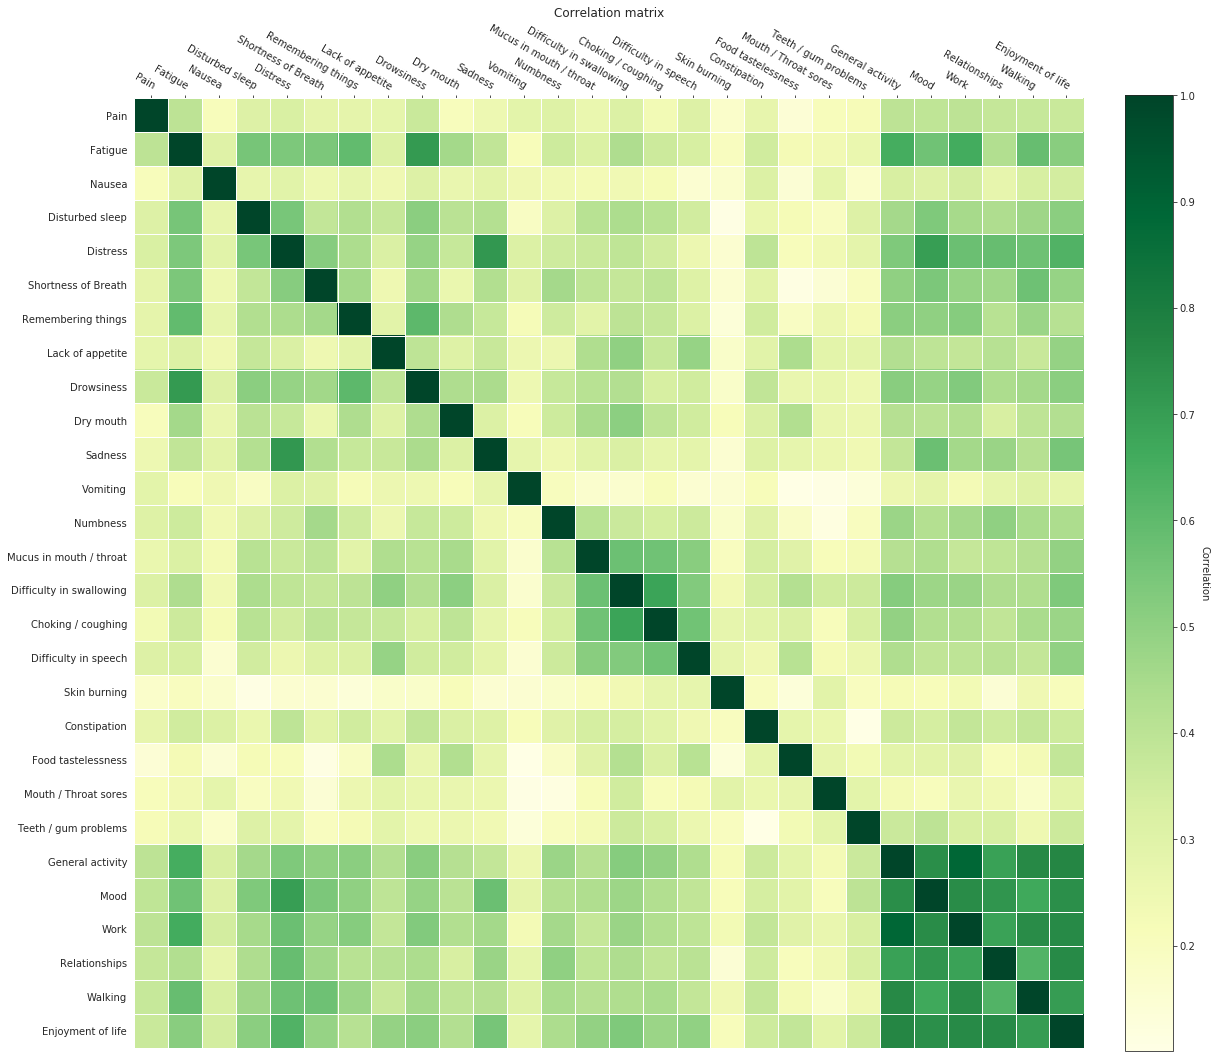

In [105]:
corr = X.corr(method='pearson')
fig = plt.figure(figsize = (17,17))
ax = fig.add_subplot(111)

img, cbar = heatmap(corr, symptoms, symptoms, 
                    ax=ax, cmap='YlGn', cbarlabel='Correlation', 
                    cbar_kw={'fraction': 0.046, 'pad': 0.04},
                    interpolation='nearest')
ax.set_title('Correlation matrix')
fig.tight_layout()
plt.show()
fig.savefig('output/correlation.svg', dpi=100, transparent=True)

## Let's check PCA variance ratio if used

In [106]:
pca = PCA(n_components=2, random_state=1)
X_PCA = pca.fit_transform(X)
pca.explained_variance_ratio_.cumsum()[1]

0.5106728573240956

## Elbow fitting - finding out no. of clusters that can be formed

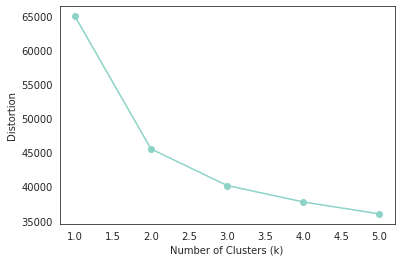

In [107]:
distortions = []
K_to_try = range(1, 6)

for i in K_to_try:
    model = KMeans(
            n_clusters=i,
            init='k-means++',
            # n_init=10,
            # max_iter=300,
            # n_jobs=-1,
            random_state=1)
    model.fit(X)
    distortions.append(model.inertia_)

plt.plot(K_to_try, distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.show()

Seems like 3 is a good fit for the clusters

Going ahead and making PCA and non PCA fits for k means model

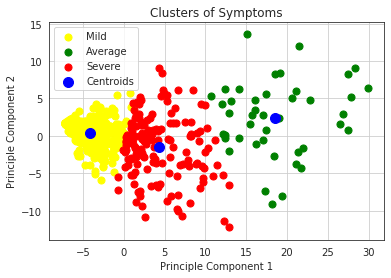

In [108]:
model = KMeans(
    n_clusters=3,
    init='k-means++',
    # n_init=10,
    # max_iter=300,
    # n_jobs=-1,
    random_state=1)

model = model.fit(X_PCA)

y = model.predict(X_PCA)

plt.scatter(X_PCA[y == 0, 0], X_PCA[y == 0, 1], s = 50, c = 'yellow', label = 'Mild')
plt.scatter(X_PCA[y == 1, 0], X_PCA[y == 1, 1], s = 50, c = 'green', label = 'Average')
plt.scatter(X_PCA[y == 2, 0], X_PCA[y == 2, 1], s = 50, c = 'red', label = 'Severe')
plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], s = 100, c = 'blue', label = 'Centroids')
plt.title('Clusters of Symptoms')
plt.xlabel('Principle Component 1')
plt.ylabel('Principle Component 2')
plt.legend()
plt.grid()
plt.show()

### Cluster count

In [109]:
collections.Counter(y)

Counter({0: 342, 2: 151, 1: 43})

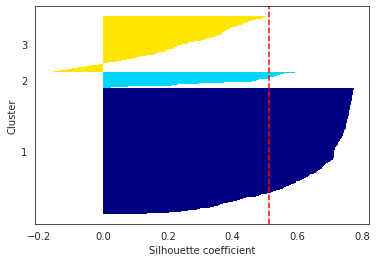

In [110]:
cluster_labels = np.unique(y)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X_PCA, y, metric='euclidean')

y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none',
            color=color)
    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
silhouette_avg = np.mean(silhouette_vals)

plt.axvline(silhouette_avg, color="red", linestyle="--")
plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')
plt.show()

In [111]:
# use best k from Elbow method
model_k = KMeans(
    n_clusters=3,
    init='k-means++',
    # n_init=10,
    # max_iter=300,
    # n_jobs=-1,
    random_state=1)

# fit with X instead of X_pca
model_k = model_k.fit(X)
y_final = model_k.predict(X)

collections.Counter(y_final)

Counter({0: 330, 2: 159, 1: 47})

In [112]:
x = df_train.iloc[:, 0:1]
X = pd.concat([X, x], axis=1)
y_final = pd.DataFrame(y_final, columns=['cluster'])
raw_result = pd.concat([X, y_final], axis=1)
y = pd.DataFrame(y, columns=['cluster'])
raw_result_pca = pd.concat([X, y], axis=1)

raw_result.to_csv('output/raw_result.csv', index=False)
raw_result_pca.to_csv('output/raw_result_pca.csv', index=False)